#### Updating data

In [10]:
from scrapers import *
from utilities import *

In [11]:
guardianScraper()

-> No CSV file found. Creating...
-> API Query |████████████████████████████████████████| (!) 2856 in 47.3s (60.34/s) 
-> 2856 new articles saved to Guardian.csv! Total articles: 2856


In [ ]:
NYTScraper()

In [12]:
guardian_data = pd.read_csv(PARENT_DIR + "/data/Guardian.csv")
#nyt_data = pd.read_csv(PARENT_DIR + "/data/NYT.csv")
guardian_data.head()

,URL,Date,Title,Text
0,https://www.theguardian.com/world/2022/jan/31/...,2022-02-01T08:07:51Z,Moscow warns Ukraine may ‘destroy itself’ as R...,Ukraine will be responsible for its own destru...
1,https://www.theguardian.com/world/commentisfre...,2022-02-01T13:00:55Z,From eastern Europe we watch Ukraine in fear. ...,Two points about the Ukraine crisis are crysta...
2,https://www.theguardian.com/politics/2022/feb/...,2022-02-01T14:22:11Z,Johnson-Putin call rescheduled as PM’s diploma...,A phone call between Boris Johnson and Vladimi...
3,https://www.theguardian.com/politics/2022/feb/...,2022-02-01T16:00:02Z,Nicola Sturgeon urges Johnson to tackle Russia...,Nicola Sturgeon has called on the prime minist...
4,https://www.theguardian.com/commentisfree/2022...,2022-02-01T16:00:02Z,Britain’s failure to tackle Russian dirty mone...,The prospect of war in our continent is more t...


#### Stopword removal with Gensim

In [2]:
import spacy
import gensim
from spacy.lang.en import English
from gensim.parsing.preprocessing import remove_stopwords
#!python -m spacy download en_core_web_sm

In [5]:
guardian_data = guardian_data.dropna(subset=['Text'])
guardian_texts = guardian_data['Text'].tolist()
guardian_no_sw = []
for text in guardian_texts:
    text_no_sw = remove_stopwords(text)
    guardian_no_sw.append(text_no_sw) 
guardian_data['Text'] = guardian_no_sw

#nyt_data = nyt_data.dropna(subset=['Text'])
#nyt_texts = nyt_data['Text'].tolist()
#nyt_no_sw = []
#for text in nyt_texts:
#    text_no_sw = remove_stopwords(text)
#    nyt_no_sw.append(text_no_sw) 
#nyt_data['Text'] = nyt_no_sw

guardian_data.to_csv(PARENT_DIR + "/data/Guardian_no_sw.csv", index=False)
#nyt_data.to_csv(PARENT_DIR + "/data/NYT_no_sw.csv", index=False)


#### LDA topic identification

In [13]:
import argparse
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from gensim.parsing.preprocessing import remove_stopwords
from lda import LDA

In [14]:
def learn_topics(dataframe, topicnum):

    # Removes stopwords
    texts = dataframe['Text'].tolist()
    texts_no_sw = []
    for text in texts:
        text_no_sw = remove_stopwords(text)
        texts_no_sw.append(text_no_sw) 
    texts = texts_no_sw

    # Get vocabulary and word counts.  Use the top 10,000 most frequent
    # lowercase unigrams with at least 2 alphabetical, non-numeric characters,
    # punctuation treated as separators.
    CVzer = CountVectorizer(token_pattern=r"(?u)\b[^\W\d]{2,}\b",
                            max_features=10000,
                            lowercase=True)
    doc_vcnts = CVzer.fit_transform(texts)
    vocabulary = CVzer.get_feature_names_out()

    # Learn topics.  Refresh conrols print frequency.
    lda_model = LDA(topicnum, n_iter=100, refresh=100) 
    doc_topic = lda_model.fit_transform(doc_vcnts)
    topic_word = lda_model.topic_word_
    doc_to_topic = lda_model.doc_topic_

    return doc_topic, topic_word, vocabulary, doc_to_topic

doc_topic, topic_word, vocabulary, doc_to_topic = learn_topics(guardian_data, 20) 

INFO:lda:n_documents: 2856
INFO:lda:vocab_size: 10000
INFO:lda:n_words: 1265040
INFO:lda:n_topics: 20
INFO:lda:n_iter: 100
INFO:lda:<0> log likelihood: -14570371
INFO:lda:<99> log likelihood: -10754468


In [15]:
for i in range(10):
    print(f"{guardian_data.iloc[i][2]} TOPIC: {doc_to_topic[i].argmax()}")

Moscow warns Ukraine may ‘destroy itself’ as Russia and US clash at UN TOPIC: 16
From eastern Europe we watch Ukraine in fear. Its fate could decide the continent’s future TOPIC: 4
Johnson-Putin call rescheduled as PM’s diplomacy drive falters TOPIC: 16
Nicola Sturgeon urges Johnson to tackle Russian oligarchs’ influence in UK TOPIC: 5
Britain’s failure to tackle Russian dirty money has enabled Putin’s aggression  TOPIC: 4
Russian invasion of Ukraine would be a disaster, says Boris Johnson in Kyiv TOPIC: 16
Ukraine crisis: Putin accuses US of ignoring Russian security concerns TOPIC: 16
The Guardian view on Russia: cracking down on tainted money  TOPIC: 5
Ukraine crisis a test that Britain – and Johnson – dare not fail TOPIC: 16
Kremlin calls Boris Johnson’s Ukraine diplomacy efforts ‘utterly confused’ TOPIC: 16


In [17]:
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocabulary)[np.argsort(topic_dist)][:-8:-1]
    print('Topic {}: {}'.format(i, ' '.join(topic_words)))

Topic 0: putin ukraine war us russia it biden
Topic 1: ukraine ukrainian russian the war people country
Topic 2: the crimes war said international russian evidence
Topic 3: russian russia ukraine military forces troops ukrainian
Topic 4: putin the in political but soviet years
Topic 5: uk the government sanctions money new abramovich
Topic 6: ukraine the weapons russian military defence air
Topic 7: the city people russian kyiv said soldiers
Topic 8: russia ukraine putin russian sanctions eu china
Topic 9: russian russia said sanctions the company putin
Topic 10: food said ukraine prices the world global
Topic 11: gas oil energy eu russian germany the
Topic 12: we it said he they she says
Topic 13: said refugees ukraine uk people ukrainian the
Topic 14: said ukraine ukrainian russian city russia the
Topic 15: said russian war russia media ukraine news
Topic 16: said ukraine nato the minister us president
Topic 17: it but that and like there people
Topic 18: the says guardian new march 

In [18]:
def save_topicmodel(doc_topic, topic_word, vocabulary):

    ## Topic mixtures.
    topicmixture_outpath = PARENT_DIR + "/results/GuardianTopicMixtures.txt"
    np.savetxt(topicmixture_outpath, doc_topic)

    ## Topics.
    topic_outpath = PARENT_DIR + "/results/GuardianTopics.txt"
    np.savetxt(topic_outpath, topic_word)

    ## Vocabulary order.
    vocab_outpath = PARENT_DIR + "/results/GuardianVocab.txt"
    with open(vocab_outpath, mode="w", encoding="utf-8") as f:
        for v in vocabulary:
            f.write(v + "\n")

    return topicmixture_outpath, topic_outpath, vocab_outpath

save_topicmodel(doc_topic, topic_word, vocabulary)

('d:\\Code\\ukraine-media/results/GuardianTopicMixtures.txt',
 'd:\\Code\\ukraine-media/results/GuardianTopics.txt',
 'd:\\Code\\ukraine-media/results/GuardianVocab.txt')

In [19]:

def KLdivergence_from_probdist_arrays(pdists0, pdists1):
    """
    Calculate KL divergence between probability distributions held on the same
    rows of two arrays.

    NOTE: elements of pdist* are assumed to be positive (non-zero), a
    necessary condition for using Kullback-Leibler Divergence.

    Args:
      pdists* (numpy.ndarray): arrays, where rows for each constitute the two
      probability distributions from which to calculate divergence.  pdists1
      contains the distributions holding probabilities in the numerator of the
      KL divergence summand.

    Returns:
      numpy.ndarray: KL divergences, where the second array's rows are the
        distributions in the numerator of the log in KL divergence

    """

    assert pdists0.shape == pdists1.shape, 'pdist* shapes must be identical'

    if len(pdists0.shape) == 1:
        KLdivs = (pdists1 * np.log2(pdists1/pdists0)).sum()
    elif len(pdists0.shape) == 2:
        KLdivs = (pdists1 * np.log2(pdists1/pdists0)).sum(axis=1)

    return KLdivs

In [20]:
def novelty_transience_resonance(thetas_arr, scale):
    """
    Calculate novelty, transience, and resonance for all center speeches with
    at least one scale of speeches in its past and its future.  Presidential
    speeches are excluded from the surrounding scales.
    
    Args:
      thetas_arr (numpy.ndarray): rows are topic mixtures
      scale (int): positive integer defining scale or scale size
    
    """

    # Find the first and last center speech offset, given scale size.
    speechstart = scale
    speechend = thetas_arr.shape[0] - scale

    # Calculate novelty, transience, resonance.
    novelties = []
    transiences = []
    resonances = []
    for j in range(speechstart, speechend, 1):

        center_theta = thetas_arr[j]

        # Define windows before and after center speech.
        after_boxend = j + scale + 1
        before_boxstart = j - scale

        before_theta_arr = thetas_arr[before_boxstart:j]
        beforenum = before_theta_arr.shape[0]
        before_centertheta_arr = np.tile(center_theta, reps=(beforenum, 1))

        after_theta_arr = thetas_arr[j+1:after_boxend]
        afternum = after_theta_arr.shape[0]
        after_centertheta_arr = np.tile(center_theta, reps=(afternum, 1))

        # Calculate KLDs.
        before_KLDs = KLdivergence_from_probdist_arrays(before_theta_arr,
                before_centertheta_arr)
        after_KLDs = KLdivergence_from_probdist_arrays(after_theta_arr,
                after_centertheta_arr)

        # Calculate means of KLD.
        novelty = np.mean(before_KLDs)
        transience = np.mean(after_KLDs)

        # Final measures for this center speech.
        novelties.append(novelty)
        transiences.append(transience)
        resonances.append(novelty - transience)

    return novelties, transiences, resonances

In [21]:
def save_novel_trans_reson(novelties, transiences, resonances):

    outpath = PARENT_DIR + "/results/GuardianNovelTransReson.txt"
    np.savetxt(outpath, np.vstack(zip(novelties, transiences, resonances)))

In [34]:
period = 30
novelties, transiences, resonances = novelty_transience_resonance(doc_topic, period)

for index in range(0,period):
    transiences.insert(0, 0)
    transiences.append(0)
    novelties.insert(0, 0)
    novelties.append(0)
    resonances.insert(0, 0)
    resonances.append(0)

In [23]:
save_novel_trans_reson(novelties, transiences, resonances)

C:\Users\Arthur\AppData\Local\Temp\ipykernel_4080\2825353074.py:4: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  np.savetxt(outpath, np.vstack(zip(novelties, transiences, resonances)))


In [57]:
ntr_guardian_data = guardian_data
ntr_guardian_data['Novelty'] = novelties
ntr_guardian_data['Transience'] = novelties
ntr_guardian_data['Resonance'] = resonances
ntr_guardian_data.head()
ntr_guardian_data.to_csv(PARENT_DIR + "/data/Guardian_ntr.csv", index=False)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import datetime
import numpy as np
import pandas as pd
import seaborn as sns

In [26]:
%matplotlib inline

In [58]:
ntr_guardian_data = pd.read_csv(PARENT_DIR + "/data/Guardian_ntr.csv", parse_dates=['Date'], index_col= ['Date'])

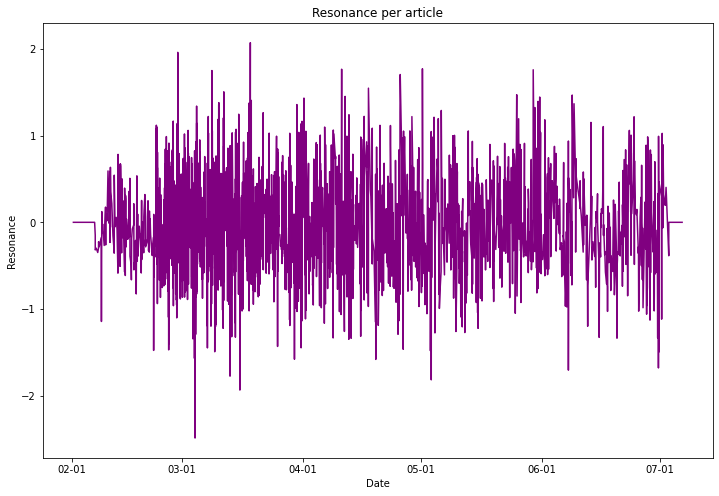

In [65]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(ntr_guardian_data.index.values,
       ntr_guardian_data['Resonance'],
       color='purple')

ax.set(xlabel="Date",
       ylabel="Resonance",
       title="Resonance per article")

date_form = DateFormatter("%m-%d")
ax.xaxis.set_major_formatter(date_form)